In [14]:
import os, sys

sys.path.append(os.getcwd())

import random
import matplotlib

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from torchcontrib.optim import SWA

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.nn.init import kaiming_uniform_, xavier_uniform_
import pickle as pkl
import geomloss #I changed the geomloss library!!!! (samples_loss.py and sinkhorn_divergence.py) to return 
                                                    #both dual potentials
torch.manual_seed(1)
np.random.seed(1)
import argparse


#TRAINING AND MODEL PARAMS
MODE = 'sink-p'  # wgan-wc or wgan-gp or sink-p or sink-np
DIM = 64  # Model dimensionality
LAMBDA = .1  # Smaller lambda seems to help for toy tasks specifically
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 256  # Batch size
EPOCHS = 80#150  # how many epochs to train for
LATENT_DIM = 32
DATA_DIM = 32
SAMPLE_SIZE = 100000
COVARIANCE_SCALE = np.sqrt(DATA_DIM)
INITIALIZATION = 'he'
if MODE == 'sink-np':
    CRITIC_ITERS = 1
    BATCH_SIZE = 256
CUDA = True
LINEAR = True
    
class Generator(nn.Module):

    def __init__(self, n_inputs = LATENT_DIM, n_neurons = DIM, data_dim = DATA_DIM, linear = LINEAR):
        super(Generator, self).__init__()
        if linear:
            main = nn.Sequential(
                nn.Linear(n_inputs, data_dim),
            )
        else:
            main = nn.Sequential(
                nn.Linear(n_inputs, n_neurons),
                nn.ReLU(True),
                nn.Linear(n_neurons, n_neurons),
                nn.ReLU(True),
                nn.Linear(n_neurons, n_neurons),
                nn.ReLU(True),
                nn.Linear(n_neurons, data_dim),
            )
        self.main = main
        self.linear = linear

    def forward(self, noise):
        output = self.main(noise)
        return output


class Discriminator(nn.Module):

    def __init__(self, n_neurons = DIM, data_dim = DATA_DIM):
        super(Discriminator, self).__init__()

        main = nn.Sequential(
            nn.Linear(data_dim, n_neurons),
            nn.ReLU(True),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(True),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(True),
            nn.Linear(n_neurons, 1),
        )
        self.main = main

    def forward(self, inputs):
        output = self.main(inputs)
        return output.view(-1)
    
class WGAN():
    def __init__(self, n_neurons = DIM, data_dim = DATA_DIM, #gp=gradient penalty
                 latent_dim = LATENT_DIM, gp = True, clip_value = (-.01,.01), penalty_strength = LAMBDA):
        self.Gen = Generator(latent_dim, n_neurons, data_dim)
        self.Disc = Discriminator(n_neurons, data_dim)
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.n_neurons = n_neurons
        self.optimizerD = None
        self.optimizerG = None
        self.gp = gp
        self.clip_value = clip_value
        self.Discs = [self.Disc]
        self.penalty_strength = penalty_strength
        self.D_real = self.D_real_test = 0 #needed for W2 on generator steps
        if gp:
            self.metrics_names = ['W2 loss','grad pen','cov diff', 'W2 loss test', 'cov diff test']
        else:
            self.metrics_names = ['W2 loss', 'cov diff', 'W2 loss test', 'cov diff test']
        self.logs = {key:{} for key in self.metrics_names}
        if not gp:
            self.logs['clip value'] = clip_value
        
    def calc_gradient_penalty(self, real_data, fake_data):
        alpha = torch.rand(fake_data.shape[0], 1).cuda()
        alpha = alpha.expand(real_data.size())

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        interpolates = autograd.Variable(interpolates, requires_grad=True)

        disc_interpolates = self.Disc(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.penalty_strength
        return gradient_penalty
    
    def disc_train(self, real_data, epoch=0, iteration=0):
        self.Disc.zero_grad()

        # train with real
        D_real = self.Disc(real_data)
        D_real = D_real.mean()

        # train with fake
        noise = torch.randn(real_data.shape[0], self.latent_dim)
        if CUDA:
            noise = noise.cuda()
        fake = self.Gen(noise).detach()
        D_fake = self.Disc(fake)
        D_fake = D_fake.mean()
        self.D_real = D_real.cpu().data
        if self.gp:
            # train with gradient penalty
            gradient_penalty = self.calc_gradient_penalty(real_data.data, fake.data)
            self.logs['grad pen'][epoch][iteration] = gradient_penalty.cpu().data.numpy()
        else:
            gradient_penalty = 0
            
        D_cost = D_fake - D_real + gradient_penalty
        D_cost.backward()#IF THIS DOESN'T work, change back to separate gradients
        Wasserstein_D = D_real - D_fake
        self.logs['W2 loss'][epoch][iteration] = Wasserstein_D.cpu().data.numpy()
        
        self.optimizerD.step()
        if not self.gp:
            # Clip weights of discriminator
            for p in self.Disc.parameters():
                p.data.clamp_(self.clip_value[0], self.clip_value[1])
                
        return D_cost.cpu().data.numpy()#, Wasserstein_D.cpu().data.numpy()
    
        
    def disc_loss(self, noise, real_data, epoch=0, iteration=0):
        D_real = self.Disc(real_data)
        D_real = D_real.mean()
        
        fake = self.Gen(noise).detach()
        D_fake = self.Disc(fake)
        D_fake = D_fake.mean()
        self.D_real_test = D_real.cpu().data
        
        Wasserstein_D = D_real - D_fake
        self.logs['W2 loss test'][epoch][iteration] = Wasserstein_D.cpu().data.numpy()
    
    def gen_train(self, cov_diff_fn, real_data=None, epoch=0, iteration=0):#real data not actually used
        
        self.Gen.zero_grad()

        noise = torch.randn(BATCH_SIZE, self.latent_dim)
        
        if CUDA:
            noise=noise.cuda()
        
        fake = self.Gen(noise)
        D_fake = self.Disc(fake)
        D_fake = D_fake.mean()
        G_cost = -D_fake
        G_cost.backward()
        self.optimizerG.step()
        Wasserstein_D = self.D_real - D_fake
        self.logs['W2 loss'][epoch][iteration] = Wasserstein_D.cpu().data.numpy()
        self.logs['cov diff'][epoch][iteration] = cov_diff_fn(fake.cpu().data.numpy())
        return G_cost.cpu().data.numpy(), fake.cpu().data.numpy()
    
    
    
    def gen_loss(self, noise, cov_diff_fn, real_data=None, epoch = 0, iteration = 0):
        
        fake = self.Gen(noise)
        D_fake = self.Disc(fake)
        D_fake = D_fake.mean()
        
        Wasserstein_D = self.D_real_test - D_fake
        self.logs['W2 loss test'][epoch][iteration] = Wasserstein_D.cpu().data.numpy()
        self.logs['cov diff test'][epoch][iteration] = cov_diff_fn(fake.cpu().data.numpy())

def initializer(weight):
    if INITIALIZATION == 'he':
        return kaiming_uniform_(weight, nonlinearity='relu')
    if INITIALIZATION == 'glorot':
        return xavier_uniform_(weight)
    print("UNKNOWN INITIALIZATION")
    return None

# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        initializer(m.weight)
        #m.bias.data.fill_(0)
        
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0.0)

# Dataset iterator
class GaussianDataset(Dataset):
    # reading the csv and defining predictor and output columns
    def __init__(self, sample_size=SAMPLE_SIZE, data_dim=DATA_DIM, latent_dim = LATENT_DIM,
                 variance = 1/COVARIANCE_SCALE):
    
        # store the input and output features
        
        np.random.seed(1)
        self.X = np.random.randn(sample_size,data_dim) * np.sqrt(variance)
        self.latent_dim = latent_dim
    
        # ensure all data is numerical - type(float)
        self.X = self.X.astype('float32')
    
    # number of rows in dataset
    def __len__(self):
        return len(self.X)
    
    # get a row at an index
    def __getitem__(self, index):
        return self.X[index]
    
def Sinkhorn_loss(x, y, epsilon, potentials = False):
    if not potentials:
        return 2 * geomloss.SamplesLoss(loss='sinkhorn', p=2, blur=np.sqrt(epsilon / 2),
                                            debias=True)(x,y)
    f_x, f_y =  geomloss.SamplesLoss(loss='sinkhorn', p=2, blur=np.sqrt(epsilon / 2),
                                            debias=True, potentials = True)(x,y)
    halved_potentials = list(f_x + f_y)
    potentials = [2 * f for f in halved_potentials]
    return potentials

class SGAN():#idea: learn the parametric discriminators using non-parametric dual potentials
    def __init__(self, n_neurons = DIM, data_dim = DATA_DIM, 
                 latent_dim = LATENT_DIM, epsilon = LAMBDA, param = True):#gp=gradient penalty
        self.Gen = Generator(latent_dim, n_neurons, data_dim)
        if param:
            self.Disc_real = Discriminator(n_neurons, data_dim)#real sample dual
            self.Disc_fake = Discriminator(n_neurons, data_dim)#fake sample dual
            self.Disc_negent = Discriminator(n_neurons, data_dim)#for negentropy dual
            self.optimizerD = None
            self.Discs = [self.Disc_real, self.Disc_fake, self.Disc_negent]
        else:
            self.Discs = []
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.n_neurons = n_neurons
        self.optimizerG = None
        self.param = param
        self.epsilon = epsilon
        #for the logs
        if param:
            self.metrics_names = ['ent W2 cost', 'negent cost', 'gen cost', 'cov diff', 'ent W2 cost test',
                             'negent cost test', 'gen cost test', 'cov diff test']
        else:
            self.metrics_names = ['Sink cost', 'cov diff', 'Sink cost test', 'cov diff test']
        self.logs = {key:{} for key in self.metrics_names}
        self.logs['lambda'] = epsilon
        
    
    def disc_train(self, real_data, epoch=0, iteration=0):
        if not self.param:
            return None
        
        for disc in self.Discs:
            disc.zero_grad()

        # real sample dual potential
        D_real = self.Disc_real(real_data)

        # fake sample dual potential
        noise = torch.randn(real_data.shape[0], self.latent_dim)
        if CUDA:
            noise=noise.cuda()
        fake_data = self.Gen(noise).detach()
        if CUDA:
            fake_data=fake_data.cuda()
        D_fake = self.Disc_fake(fake_data)
        
        #negative entropic W2
        cost_mat = (real_data.view(-1,1,DATA_DIM) - fake_data.view(1,-1,DATA_DIM)).pow(2).sum(2)
        to_exp = ((D_real.view(-1,1)+D_fake.view(1,-1) 
                                   - cost_mat)/self.epsilon)
        neg_loss_entropic = -D_real.mean()-D_fake.mean() \
                + self.epsilon * (to_exp - 2* np.log(cost_mat.shape[0])).exp().sum((0,1))
                    #.logsumexp((0,1))#exp().mean()
        neg_loss_entropic.backward()
        #(loss_negent + neg_loss_entropic).backward() #this loss function as the gradients
                                                      #are computed for non-intersecting parameters
        self.optimizerD[0].step()
        
        
        # negentropy dual potential
        D_negent = self.Disc_negent(fake_data)
        #negentropy 
        cost_mat_fake = (fake_data.view(-1,1,DATA_DIM) - fake_data.view(1,-1,DATA_DIM)).pow(2).sum(2)
        to_exp = (D_negent.view(-1,1)+D_negent.view(1,-1) - cost_mat_fake)/self.epsilon
        loss_negent = - 2. * D_negent.mean() + self.epsilon * (to_exp - 2 * np.log(cost_mat_fake.shape[0])).exp().sum((0,1))# *\
                        #(to_exp.max()).exp()##.logsumexp((0,1))#exp().mean()
        loss_negent.backward()
        self.optimizerD[1].step()
        #for i in range(len(self.optimizersD)):
        #    self.optimizersD[i].step()
        
        #Sinkhorn_D = -loss_entropic + 0.5 * loss_negent
        self.logs['negent cost'][epoch][iteration] = loss_negent.cpu().data.numpy()
        self.logs['ent W2 cost'][epoch][iteration] = neg_loss_entropic.cpu().data.numpy()
                
        return [neg_loss_entropic.cpu().data.numpy(), loss_negent.cpu().data.numpy()]
    
    def disc_loss(self, noise, real_data, epoch=0, iteration=0):
        if not self.param:
            return None
        
        # real sample dual potential
        D_real = self.Disc_real(real_data)
        D_real = D_real

        # fake sample dual potential
        fake_data = self.Gen(noise)
        D_fake = self.Disc_fake(fake_data)
        
        # negentropy dual potential
        D_negent = self.Disc_negent(fake_data)
        
        #negative entropic W2#if there are issues try the log (negative)
        cost_mat = (real_data.view(-1,1,DATA_DIM) - fake_data.view(1,-1,DATA_DIM)).pow(2).sum(2)
        neg_loss_entropic = -D_real.mean()-D_fake.mean() \
                + self.epsilon * ((D_real.view(-1,1)+D_fake.view(1,-1) - cost_mat)/self.epsilon).logsumexp((0,1))#exp().mean()
        #neg_loss_entropic.backward()
        #self.optimizersD[0].step()
        
        #negentropy 
        cost_mat_fake = (fake_data.view(-1,1,DATA_DIM) - fake_data.view(1,-1,DATA_DIM)).pow(2).sum(2)
        loss_negent = -2. * D_negent.mean()\
          + self.epsilon * ((D_negent.view(-1,1)+D_negent.view(1,-1) - cost_mat_fake)/self.epsilon).logsumexp((0,1))#exp().mean()
                
        self.logs['negent cost test'][epoch][iteration] = loss_negent.cpu().data.numpy()
        self.logs['ent W2 cost test'][epoch][iteration] = neg_loss_entropic.cpu().data.numpy()
        
    
    def gen_train(self, cov_diff_fn, real_data=None, epoch = 0, iteration = 0):
        
        self.Gen.zero_grad()
        if real_data is not None:
            noise = torch.randn(real_data.shape[0], self.latent_dim)
        else:
            noise = torch.randn(BATCH_SIZE, self.latent_dim)
        if CUDA:
            noise = noise.cuda()
        fake_data = self.Gen(noise)
        
        if not self.param:
            #f_x, f_y = geomloss.SamplesLoss(loss='sinkhorn', p=2, blur=np.sqrt(self.epsilon),
            #                            debias=True, potentials=True)(fake_data,real_data)
            #dual_x, dual_xx = f_x
            #dual_y, dual_yy = f_y
            dual_x, dual_xx, dual_y, dual_yy = Sinkhorn_loss(fake_data, real_data, 
                                                             self.epsilon, potentials = True)
        else:
            dual_x = self.Disc_fake(fake_data)
            dual_xx = self.Disc_negent(fake_data)
            dual_y = self.Disc_real(real_data)
            
            
        #cost matrices (were previously /2)
        C_xx = (fake_data.view(-1, 1, self.data_dim)
                    - fake_data.view(1,-1,self.data_dim)).square().sum(2)

        C_xy = (fake_data.view(-1, 1, self.data_dim) 
                    - real_data.view(1,-1,self.data_dim)).square().sum(2)

        #probabilities
        N = real_data.shape[0]
        pi_xx_log = ((dual_xx.view(-1, 1) + dual_xx.view(1,-1)) - C_xx) / self.epsilon
        pi_xx = (pi_xx_log - pi_xx_log.max()).exp()
        pi_xx_log -= pi_xx.sum().log()
        pi_xx /= pi_xx.sum()
        
        pi_xy_log = ((dual_x.view(-1, 1) + dual_y.view(1,-1)) - C_xy) / self.epsilon
        pi_xy = (pi_xy_log - pi_xy_log.max()).exp()
        pi_xy_log -= pi_xy.sum().log()
        pi_xy /= pi_xy.sum()
        
        grad = (pi_xx.view(N, N, 1) * fake_data.view(1, N, self.data_dim) - 
                    pi_xy.view(N, N, 1) * real_data.view(1, N, self.data_dim)).sum(1).detach()
        
        loss = (grad * fake_data).sum()
        #loss = dual_x.mean() + dual_y.mean() - dual_xx.mean()
        loss.backward()
        self.optimizerG.step()
            
        
        if not self.param:
            Sinkhorn_D = (dual_x - dual_xx).mean() + (dual_y - dual_yy).mean()
            self.logs['Sink cost'][epoch][iteration] = Sinkhorn_D.cpu().data.numpy()
            
        
        else:#MAYBE CHANGE LOSS CALCULATION HERE TO MATCH WHAT WAS IN "ON THE CONVERGENCE AND ROBUSTNESS..."
            
            #ASSUMING OPTIMAL DUAL POTENTIALS:
            #Sinkhorn_D = dual_x.mean() - dual_xx.mean()
        
            #Sinkhorn_D.backward()
            #self.optimizerG.step()
            
            Sinkhorn_D = (pi_xy * C_xy - self.epsilon * pi_xy * pi_xy_log).sum() - \
                0.5 * (pi_xx * C_xx - self.epsilon * pi_xx * pi_xx_log).sum()# - \
                #0.5 * Sinkhorn_loss(real_data, real_data, self.epsilon)#last term not necessary
            
            self.logs['gen cost'][epoch][iteration] = Sinkhorn_D.cpu().data.numpy()
        
        
        self.logs['cov diff'][epoch][iteration] = cov_diff_fn(fake_data.cpu().data.numpy())
        return Sinkhorn_D.cpu().data.numpy(), fake_data.cpu().data.numpy()
        
    
    def gen_loss(self, noise, cov_diff_fn, real_data=None, epoch = 0, iteration = 0):
        
        self.Gen.zero_grad()
        fake_data = self.Gen(noise)
        
        if not self.param:
            Sinkhorn_D = Sinkhorn_loss(fake_data, real_data, self.epsilon)
            self.logs['Sink cost test'][epoch][iteration] = Sinkhorn_D.cpu().data.numpy()
            
        
        else:#MAYBE CHANGE LOSS CALCULATION HERE TO MATCH WHAT WAS IN "ON THE CONVERGENCE AND ROBUSTNESS..."
            dual_x = self.Disc_fake(fake_data)
            dual_xx = self.Disc_negent(fake_data)
            dual_y = self.Disc_real(real_data)
            #cost matrices (were previously /2)
            C_xx = (fake_data.view(-1, 1, self.data_dim)
                        - fake_data.view(1,-1,self.data_dim)).square().sum(2)

            C_xy = (fake_data.view(-1, 1, self.data_dim) 
                        - real_data.view(1,-1,self.data_dim)).square().sum(2)

            #probabilities
            N = real_data.shape[0]
            pi_xx_log = ((dual_xx.view(-1, 1) + dual_xx.view(1,-1)) - C_xx) / self.epsilon
            pi_xx = (pi_xx_log - pi_xx_log.max()).exp()
            pi_xx_log -= pi_xx.sum().log()
            pi_xx /= pi_xx.sum()

            pi_xy_log = ((dual_x.view(-1, 1) + dual_y.view(1,-1)) - C_xy) / self.epsilon
            pi_xy = (pi_xy_log - pi_xy_log.max()).exp()
            pi_xy_log -= pi_xy.sum().log()
            pi_xy /= pi_xy.sum()

            Sinkhorn_D = (pi_xy * C_xy - self.epsilon * pi_xy * pi_xy_log).sum() - \
                0.5 * (pi_xx * C_xx - self.epsilon * pi_xx * pi_xx_log).sum() #- \
                #0.5 * Sinkhorn_loss(real_data, real_data, self.epsilon)#last term not necessary
            self.logs['gen cost test'][epoch][iteration] = Sinkhorn_D.cpu().data.numpy()
        
        
        self.logs['cov diff test'][epoch][iteration] = cov_diff_fn(fake_data.cpu().data.numpy())
        return Sinkhorn_D.cpu().data.numpy(), fake_data.cpu().data.numpy()
    
    
class cov_metric():
    def __init__(self, data_dim = DATA_DIM, average = False):
        if average:
            self.cov = np.zeros((data_dim,data_dim))
            self.n_seen = 0
            self.mean = np.zeros(data_dim)
        self.optimal_cov = np.eye(data_dim) / COVARIANCE_SCALE
        self.data_dim = data_dim
        self.average = average
    def update(self, fake_data, model = None):
        if model is not None:
            W = model.Gen.main[0].weight.cpu().data.numpy()
            self.cov = W.dot(W.T)
        else:
            sample_cov = np.cov(fake_data.T)
            if self.average:
                data_frac = self.n_seen / (self.n_seen + fake_data.shape[0])
                sample_mean = np.mean(fake_data, axis = 0)
                self.cov = data_frac * (self.cov + np.outer(self.mean, self.mean)) \
                        + (1 - data_frac) * (sample_cov + np.outer(sample_mean, sample_mean))
                self.mean = data_frac * self.mean + (1 - data_frac) * sample_mean
            else:
                self.cov = sample_cov
        return np.linalg.norm(self.cov - self.optimal_cov)
    
def plot_logs(key, logs):
    y = []#key
    x = []#iterations
    iters_passed = 0
    for epoch in sorted(list(logs[key].keys())):
        for it in sorted(list(logs[key][epoch].keys())):
            y += [logs[key][epoch][it]]
            x += [it + iters_passed]
        iters_passed += it+1
        
    return x, y

In [15]:

dataset = GaussianDataset()
data_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)


if MODE == 'wgan-gp':
    model = WGAN()
elif MODE == 'wgan-wc':
    model = WGAN(gp = False)
elif MODE == 'sink-np':
    model = SGAN(param = False)
elif MODE == 'sink-p':
    model = SGAN()

if CUDA:
    model.Gen.cuda()
    for disc in model.Discs:
        disc.cuda()

model.Gen.apply(weights_init)
for disc in model.Discs:
    disc.apply(weights_init);
    
if MODE == 'wgan-gp':   
    if BATCH_SIZE != 2560:
        model.optimizerD = optim.Adam(model.Disc.parameters(), lr=1e-3, betas=(0.5, 0.9))
        model.optimizerG = optim.Adam(model.Gen.parameters(), lr=1e-3, betas=(0.5, 0.9))
        def lmb(epoch):
            return 1

        schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
        schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerD, lmb)
        LAMBDA = model.penalty_strength = 0.01
    else:
        model.optimizerD = optim.RMSprop(model.Disc.parameters(), lr=1e-2)#optim.RMSprop(model.Disc.parameters(), lr=5e-3)#optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
        model.optimizerG = optim.RMSprop(model.Gen.parameters(), lr=1e-2)#optim.RMSprop(model.Gen.parameters(), lr=5e-3)#optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)
    
        def lmb(epoch):
            return .5 if epoch%10==0 and epoch > 0 and epoch !=20 and epoch !=50 else 1

        schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
        schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerD, lmb)
        LAMBDA = model.penalty_strength = 0.001
    
elif MODE == 'wgan-wc':
    model.optimizerD = optim.RMSprop(model.Disc.parameters(), lr=1e-2)#optim.RMSprop(model.Disc.parameters(), lr=5e-3)#optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
    model.optimizerG = optim.RMSprop(model.Gen.parameters(), lr=1e-2)#optim.RMSprop(model.Gen.parameters(), lr=5e-3)#optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)
    
    def lmb(epoch):
        return .5 if epoch%10==0 and epoch > 0 else 1
    
    schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
    schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerD, lmb)
    LAMBDA = .01
    
elif MODE == 'sink-p':
    #model.optimizerD = optim.Adam(list(model.Discs[0].parameters()) 
    #                         + list(model.Discs[1].parameters()) 
    #                                +list(model.Discs[2].parameters()), lr=1e-4, betas=(0.5, 0.9))
    #model.optimizerG = optim.Adam(model.Gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
    #LAMBDA = model.epsilon = 12.
    model.optimizerD = optim.RMSprop(list(model.Discs[0].parameters()) 
                             + list(model.Discs[1].parameters()) 
                                    +list(model.Discs[2].parameters()), lr=1e-2)#optim.RMSprop(model.Disc.parameters(), lr=5e-3)#optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
    model.optimizerG = optim.RMSprop(model.Gen.parameters(), lr=1e-2)#optim.RMSprop(model.Gen.parameters(), lr=5e-3)#optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)
    
    def lmb(epoch):
        return .5 if epoch%10==0 and epoch > 10 else 1
    
    schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
    schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerD, lmb)
    LAMBDA = model.epsilon = 12.
elif MODE == 'sink-np':
    model.optimizerG = optim.Adam(model.Gen.parameters(), lr=5e-3, betas=(0.5, 0.9))
    #optim.RMSprop(model.Gen.parameters(), lr=1e-2)#model.optimizerG = optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)
    #optim.Adam(model.Gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
    def lmb(epoch):
        return .5 if epoch%10==0 and epoch > 0 and epoch <=60 else 1
    
    schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
    schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lambda X: 1.)
    LAMBDA = model.epsilon = 12.
    
average_cov = False
model.logs['batch size'] = BATCH_SIZE
model.logs['critic iters'] = CRITIC_ITERS
model.logs['mode'] = MODE
model.logs['lambda'] = LAMBDA

if 'weights' not in model.logs:
    model.logs['weights'] = {}

    
real_data_test = torch.FloatTensor(np.random.randn(2560, 32) / np.sqrt(COVARIANCE_SCALE))
noise_test = torch.FloatTensor(np.random.randn(2560, 32))

if CUDA:
    real_data_test = real_data_test.cuda()
    noise_test = noise_test.cuda()

plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
if MODE == 'wgan-gp':
    model_name = "WGAN_GP"
elif MODE == 'wgan-wc':
    model_name = "WGAN_WC"
elif MODE == 'sink-np':
    model_name = "SINKHORN_NP"
elif MODE == 'sink-p':
    model_name = "SINKHORN_P"
model_name = model_name + "_LATENT_DIM_" + str(LATENT_DIM) + "_initialization_" + INITIALIZATION + "_LAMBDA_" + str(LAMBDA) + "_BATCHSIZE_" +str(BATCH_SIZE)
model_name += '_v2_linear'

print(model_name)

SINKHORN_P_LATENT_DIM_32_initialization_he_LAMBDA_12.0_BATCHSIZE_256_v2_linear


In [17]:
if 'weights' not in model.logs:
    model.logs['weights'] = {}

In [18]:

#model.optimizerD = optim.RMSprop(model.Disc.parameters(), lr=1e-2)#optim.RMSprop(model.Disc.parameters(), lr=5e-3)#optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
#model.optimizerG = optim.RMSprop(model.Gen.parameters(), lr=1e-2)#optim.RMSprop(model.Gen.parameters(), lr=5e-3)#optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)

#def lmb(epoch):
#    return .5 if epoch%10==0 and epoch > 0 else 1#

#schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
#schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lambda x: 1.)

In [19]:
model.optimizerD = [optim.RMSprop(list(model.Discs[0].parameters()) 
                         + list(model.Discs[1].parameters()), lr=1e-3) ,
                        optim.RMSprop(list(model.Discs[2].parameters()), lr=1e-3)]
                        #optim.RMSprop(model.Disc.parameters(), lr=5e-3)
                        #optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
model.optimizerG = optim.RMSprop(model.Gen.parameters(), lr=1e-3)#optim.RMSprop(model.Gen.parameters(), lr=5e-3)#optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)

def lmb(epoch):
    return 1#.5 if epoch%10==0 and epoch > 10 else 1

schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerD[0], lmb)

In [25]:
model.optimizerG.param_groups[0]['lr'] /= 2
model.optimizerD[0].param_groups[0]['lr'] /=2
model.optimizerD[1].param_groups[0]['lr'] /=2#at epoch 20, 30, 40

In [20]:
CRITIC_ITERS = 5

e 20,i 4, ent W2 cost 2.41441, negent cost 3.79402, gen cost 71.25638, cov diff 0.29056, ent W2 cost test 178.66245, negent cost test 180.18910, gen cost test 97.92731, cov diff test: 0.29056,
e 20,i 9, ent W2 cost 2.32219, negent cost 3.85006, gen cost 71.30394, cov diff 0.29045, ent W2 cost test 178.66377, negent cost test 180.19202, gen cost test 97.78545, cov diff test: 0.29045,
e 20,i 14, ent W2 cost 2.28153, negent cost 4.01566, gen cost 71.20702, cov diff 0.29000, ent W2 cost test 178.66353, negent cost test 180.19147, gen cost test 97.87078, cov diff test: 0.29000,
e 20,i 19, ent W2 cost 2.43186, negent cost 4.07403, gen cost 69.88744, cov diff 0.28978, ent W2 cost test 178.66203, negent cost test 180.18843, gen cost test 97.85092, cov diff test: 0.28978,
e 20,i 24, ent W2 cost 2.16748, negent cost 3.70671, gen cost 71.57143, cov diff 0.28952, ent W2 cost test 178.66212, negent cost test 180.18863, gen cost test 97.86411, cov diff test: 0.28952,
e 20,i 29, ent W2 cost 2.27446, 

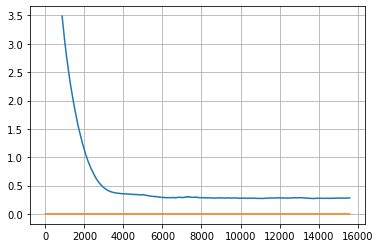

In [26]:
for epoch in range(20, 40):
    cov_diff = cov_metric(average=average_cov)
    if model.Gen.linear:
        cov_diff_upd = lambda x: cov_diff.update(x, model = model)
    else:
        cov_diff_upd = cov_diff.update
    #if epoch > 0:a
    
    for key in model.metrics_names:
        model.logs[key][epoch] = {}
    model.logs['weights'][epoch] = {}
    for iteration, _data in enumerate(data_dl):
        if _data.shape[0] !=BATCH_SIZE:
            continue
        #lr_scheduler(epoch, model)
        
        ############################
        # (1) Update D network CRITIC_ITERS iterations
        ###########################
        if CUDA:
            _data = _data.cuda()
        model.disc_train(_data, epoch=epoch, iteration=iteration)
        model.disc_loss(noise_test,real_data_test, epoch=epoch, iteration=iteration)
        if iteration % CRITIC_ITERS == CRITIC_ITERS - 1 :
            ############################
            # (2) Update G network
            ###########################
            #ms = model.optimizerG.state_dict()
            model.gen_train(real_data=_data, cov_diff_fn=cov_diff_upd, epoch=epoch, iteration=iteration)
            model.gen_loss(noise_test, cov_diff_upd, real_data_test, epoch, iteration)
            metrics = [model.logs[key][epoch][iteration] for key in model.metrics_names]
            print(('e {},i {}, '+' {:.5f}, '.join(model.metrics_names) + ': {:.5f},').format(epoch,
                                                                                iteration,*metrics))
            model.logs['weights'][epoch][iteration] = [{}]
            for key in model.Gen.state_dict():
                model.logs['weights'][epoch][iteration][0][key] = \
                    model.Gen.state_dict()[key].data.cpu().numpy()
            for k, disc in enumerate(model.Discs):
                model.logs['weights'][epoch][iteration] += [{}]
                for key in disc.state_dict():
                    model.logs['weights'][epoch][iteration][k+1][key] = \
                        disc.state_dict()[key].data.cpu().numpy()
            #model.logs['weights'][epoch][iteration] = [model.Gen.state_dict()]+ \
            #                            [disc.state_dict() for disc in model.Discs]
    if (epoch+1) % 5 == 0:
        with open('./training_linear/jp' + model_name + '.pkl', 'wb') as f:
            pkl.dump(model.logs, f)
            
        #print(model_logs['cov diff test'])
        plt.clf()
        plt.grid("on", "both")
        x, y = plot_logs('cov diff test', model.logs)
        if len(y) == 0:
            print('error')
        if np.max(np.array(y)) <= 3.5:
            idx = 0
        else:
            idx = np.max(np.where(np.array(y) > 3.5))+1
        plt.plot(x[idx:], y[idx:])
        plt.plot(x, np.zeros(len(x)))
        plt.savefig("./plots_linear/jp_accuracy_history_"+model_name+".png")
    #schedulerD.step()
    #schedulerG.step()
    #if MODE == 'sink-np' and epoch == 18:
    #    model.optimizerG = optim.Adam(model.Gen.parameters(), lr=1e-5, betas = (0.25, 0.45))
    

In [22]:
#logs = {}
logs['separate optimizers D, no_log_o_max_disc_term, reg_gen, RMSprop 1e-3, lambda ' + str(model.epsilon)] = [model.logs, model]

In [23]:
torch.cuda.empty_cache()

In [64]:
#true calculations give 0.3 error with 20 epochs
#if no regularization term is used for generator we get 0.64 error

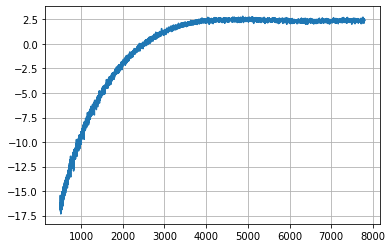

In [65]:
st = 500
x, y = plot_logs(model.metrics_names[0], model.logs)
plt.plot(x[st:], y[st:])
plt.grid('on', 'both')

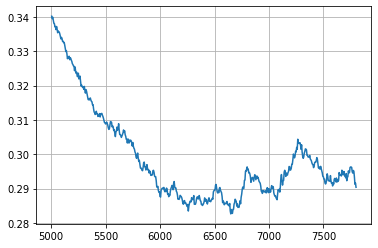

In [24]:
st = 1000
x, y = plot_logs('cov diff test', model.logs)
plt.plot(x[st:], y[st:])
plt.grid('on', 'both')

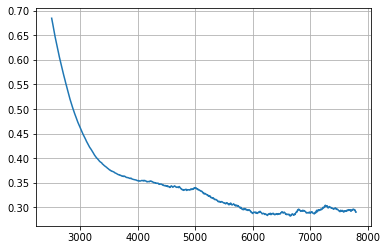

In [66]:
#no log disc
st = 500
x, y = plot_logs('cov diff test', model.logs)
plt.plot(x[st:], y[st:])
plt.grid('on', 'both')

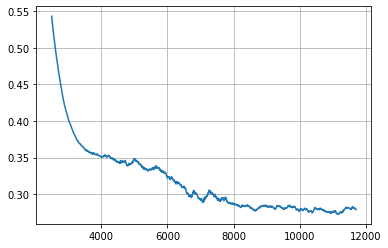

In [17]:
st = 500
x, y = plot_logs('cov diff test', model.logs)
plt.plot(x[st:], y[st:])
plt.grid('on', 'both')

In [219]:
W = model.Gen.main[0].weight.cpu().data.numpy()
b = model.Gen.main[0].bias.cpu().data.numpy()

In [220]:
def lr_scheduler(epoch, model):
    if MODE == 'sink-np':
        if epoch < 10:
            model.optimizerG.param_groups[0]['lr'] = 1. #0.27 test covariance diff 0.267 and 0.235 test Sink div 
        elif epoch <20:
            model.optimizerG.param_groups[0]['lr'] = 0.5 #0.267 cov 0.235 Sink div 
        elif epoch <30:
            model.optimizerG.param_groups[0]['lr'] = 0.25 #0.267 cov 0.235 Sink div
        elif epoch <40:
            model.optimizerG.param_groups[0]['lr'] = 0.175 #0.267 cov 0.235 Sink div
        elif epoch <50:
            model.optimizerG.param_groups[0]['lr'] = 0.09 #0.267 cov 0.235 Sink div
        elif epoch < 60: 
            model.optimizerG.param_groups[0]['lr'] = 0.05 #0.267 cov 0.235 Sink div
        elif epoch < 80: 
            model.optimizerG.param_groups[0]['lr'] = 0.025#0.267 cov 0.235 Sink div
        elif epoch < 100: 
            model.optimizerG.param_groups[0]['lr'] = 0.01
        elif epoch < 120: 
            model.optimizerG.param_groups[0]['lr'] = 0.005
        elif epoch == 120:
            base_opt = optim.SGD(model.Gen.parameters(), lr=5e-3)#, momentum = 0.9)
            model.optimizerG = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.005)
    #return 0.01
    if MODE == 'wgan-wc':
        if epoch == 10:
            model.optimizerD = optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
            model.optimizerG = optim.SGD(model.Gen.parameters(), lr=1., momentum = 0.5)
#        elif epoch <20:
#            model.optimizerG.param_groups[0]['lr'] = .5 #0.267 cov 0.235 Sink div 
#            model.optimizerD.param_groups[0]['lr'] = .5
#         elif epoch <30:
#             model.optimizerG.param_groups[0]['lr'] = 0.25 #0.267 cov 0.235 Sink div
#             model.optimizerD.param_groups[0]['lr'] = .25
#         elif epoch <40:
#             model.optimizerG.param_groups[0]['lr'] = 0.175 #0.267 cov 0.235 Sink div
#             model.optimizerD.param_groups[0]['lr'] = .175
#         elif epoch <50:
#             model.optimizerG.param_groups[0]['lr'] = 0.09 #0.267 cov 0.235 Sink div
#             model.optimizerD.param_groups[0]['lr'] = .09
#         elif epoch < 60: 
#             model.optimizerG.param_groups[0]['lr'] = 0.05 #0.267 cov 0.235 Sink div
#             model.optimizerD.param_groups[0]['lr'] = .05
#         elif epoch < 80: 
#             model.optimizerG.param_groups[0]['lr'] = 0.025#0.267 cov 0.235 Sink div
#         elif epoch < 100: 
#             model.optimizerG.param_groups[0]['lr'] = 0.01
#         elif epoch < 120: 
#             model.optimizerG.param_groups[0]['lr'] = 0.005
#         elif epoch == 120:
#             base_opt = optim.SGD(model.Gen.parameters(), lr=5e-3)#, momentum = 0.9)
#             model.optimizerG = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.005)
  

In [221]:
#model.Gen.main[0].weight = nn.Parameter(torch.FloatTensor(np.sqrt(cov_diff_fn.optimal_cov)))
#model.Gen.cuda()

In [222]:
model.epsilon = 12.

In [780]:
#model.optimizerD = optim.RMSprop(model.Disc.parameters(), lr=1e-2)#optim.RMSprop(model.Disc.parameters(), lr=5e-3)#optim.SGD(model.Disc.parameters(), lr=1., momentum = 0.5)
model.optimizerG = optim.RMSprop(model.Gen.parameters(), lr=1e-2)#Adam(model.Gen.parameters(), lr=1e-2, betas=(0.5, 0.9))

In [770]:
def lmb(epoch):
    return .5 if epoch%5==0 and epoch > 0 else 1

In [767]:
#schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)
#schedulerD = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerD, lmb)
#torch.optim.lr_scheduler.CyclicLR(model.optimizerG, base_lr = 1e-2, max_lr=.1, 
#          step_size_up=5*(len(data_dl)-1),base_momentum=0.0, 
#                                              max_momentum=0.5)

In [768]:
model.optimizerG.param_groups[0]['lr'] = 0.005#epoch 5
#epoch 7+ -- problem (increase)
model.optimizerG.param_groups[0]['lr'] = 0.0025#epoch 9
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 12
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 14
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 16
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 17
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 18
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 24
model.optimizerG.param_groups[0]['lr'] /= 2#epoch 28

In [636]:
model.optimizerG.param_groups[0]['alpha'] = 0.9#epoch 32
model.optimizerG.param_groups[0]['lr'] *= 2#epoch 40

In [782]:
def lmb(epoch):
    if epoch <= 16:
        return .5 if epoch%2==0 and epoch > 0 else 1
schedulerG = torch.optim.lr_scheduler.MultiplicativeLR(model.optimizerG, lmb)

In [974]:
model_name

'WGAN_WC_LATENT_DIM_32_initialization_he_LAMBDA_0.1_BATCHSIZE_2560_v2_linear'

In [975]:
def plot_logs(key, logs):
    y = []#key
    x = []#iterations
    iters_passed = 0
    for epoch in sorted(list(logs[key].keys())):
        for it in sorted(list(logs[key][epoch].keys())):
            y += [logs[key][epoch][it]]
            x += [it + iters_passed]
        iters_passed += it+1
        
    return x, y

In [987]:
W = model.Gen.main[0].weight.cpu().data.numpy()
#b = model.Gen.main[0].bias.cpu().data.numpy()

In [988]:
np.linalg.norm(W.dot(W.T) - cov_diff_fn.optimal_cov)

0.04018680348241027

In [977]:
model.Gen.main[0].weight = nn.Parameter(torch.FloatTensor(W))
model.Gen.main[0].bias = nn.Parameter(torch.FloatTensor(b))
model.Gen.cuda()

Generator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [947]:
model.optimizerG = optim.Adam(model.Gen.parameters(), lr=1e-5, betas = (0.25, 0.45))#SGD(model.Gen.parameters(), lr=5e-3, momentum = 0.7)#RMSprop(model.Gen.parameters(), lr=5e-6, alpha = 0.5)#

epoch: 30, iter: 0, Sink cost: 0.00856, cov diff: 0.03834, Sink cost test: 0.00656, cov diff test: 0.03834,
epoch: 30, iter: 1, Sink cost: 0.00697, cov diff: 0.03834, Sink cost test: 0.00656, cov diff test: 0.03834,
epoch: 30, iter: 2, Sink cost: 0.00564, cov diff: 0.03834, Sink cost test: 0.00656, cov diff test: 0.03834,
epoch: 30, iter: 3, Sink cost: 0.00717, cov diff: 0.03835, Sink cost test: 0.00656, cov diff test: 0.03835,
epoch: 30, iter: 4, Sink cost: 0.00535, cov diff: 0.03834, Sink cost test: 0.00656, cov diff test: 0.03834,
epoch: 30, iter: 5, Sink cost: 0.00616, cov diff: 0.03835, Sink cost test: 0.00656, cov diff test: 0.03835,
epoch: 30, iter: 6, Sink cost: 0.00731, cov diff: 0.03835, Sink cost test: 0.00656, cov diff test: 0.03835,
epoch: 30, iter: 7, Sink cost: 0.00716, cov diff: 0.03835, Sink cost test: 0.00656, cov diff test: 0.03835,
epoch: 30, iter: 8, Sink cost: 0.00799, cov diff: 0.03836, Sink cost test: 0.00656, cov diff test: 0.03836,
epoch: 30, iter: 9, Sink cos

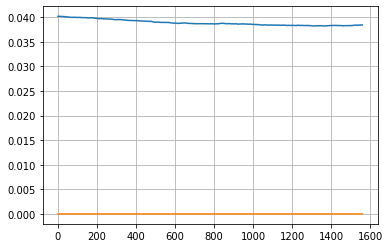

In [952]:
for epoch in range(30, 40):#(EPOCHS):
    cov_diff = cov_metric(average=average_cov)
    if model.Gen.linear:
        cov_diff_upd = lambda x: cov_diff.update(x, model = model)
    else:
        cov_diff_upd = cov_diff.update
    #if epoch > 0:a
    
    for key in model.metrics_names:
        model.logs[key][epoch] = {}
    model.logs['weights'][epoch] = {}
    for iteration, _data in enumerate(data_dl):
        if _data.shape[0] !=BATCH_SIZE:
            continue
        #lr_scheduler(epoch, model)
        
        ############################
        # (1) Update D network CRITIC_ITERS iterations
        ###########################
        if CUDA:
            _data = _data.cuda()
        model.disc_train(_data, epoch=epoch, iteration=iteration)
        model.disc_loss(noise_test,real_data_test, epoch=epoch, iteration=iteration)
        if iteration % CRITIC_ITERS == CRITIC_ITERS - 1 :
            ############################
            # (2) Update G network
            ###########################
            #ms = model.optimizerG.state_dict()
            model.gen_train(real_data=_data, cov_diff_fn=cov_diff_upd, epoch=epoch, iteration=iteration)
            model.gen_loss(noise_test, cov_diff_upd, real_data_test, epoch, iteration)
            metrics = [model.logs[key][epoch][iteration] for key in model.metrics_names]
            print(('epoch: {}, iter: {}, '+': {:.5f}, '.join(model.metrics_names) + ': {:.5f},').format(epoch,
                                                                                iteration,*metrics))
            model.logs['weights'][epoch][iteration] = [model.Gen.state_dict()]+ \
                                        [disc.state_dict() for disc in model.Discs]
        #scheduler.step()
    if epoch >= 120:
        model.optimizerG.swap_swa_sgd()
        
    if (epoch+1) % 5 == 0:
        with open('./training_linear/jp' + model_name + '.pkl', 'wb') as f:
            pkl.dump(model.logs, f)
            
        #print(model_logs['cov diff test'])
        plt.clf()
        plt.grid("on", "both")
        x, y = plot_logs('cov diff test', model.logs)
        if len(y) == 0:
            print('error')
        if np.max(np.array(y)) <= 3.5:
            idx = 0
        else:
            idx = np.max(np.where(np.array(y) > 3.5))+1
        plt.plot(x[idx:], y[idx:])
        plt.plot(x, np.zeros(len(x)))
        plt.savefig("./plots_linear/jp_accuracy_history_"+model_name+".png")
    #schedulerD.step()
    #schedulerG.step()
    

In [785]:
np.linalg.norm(W.T.dot(W) - cov_diff_fn.optimal_cov)

0.04018678678258883

In [482]:
np.linalg.norm(W.T.dot(W) - cov_diff_fn.optimal_cov)

0.027092212365437456

In [483]:
l, _ = np.linalg.eigh(W.dot(W.T))

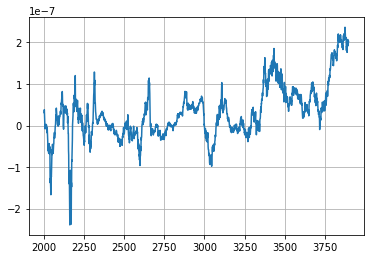

In [983]:
st = 2000
x, y = plot_logs('W2 loss test', model.logs)
plt.plot(x[st:], y[st:])
plt.grid('on', 'both')

In [760]:
650/39

16.666666666666668

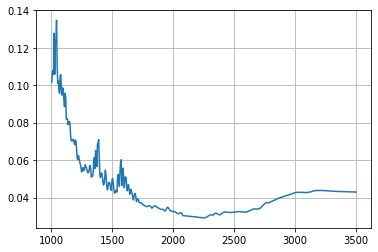

In [984]:
st = 200
x, y = plot_logs('cov diff test', model.logs)
plt.plot(x[st:], y[st:])
plt.grid('on', 'both')

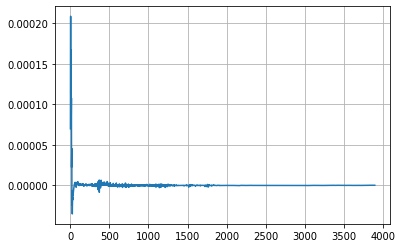

In [980]:
plt.plot(*plot_logs('W2 loss test', model.logs))
plt.grid('on', 'both')

In [342]:

x, y =plot_logs('W2 loss', model.logs)

KeyError: 'W2 loss'

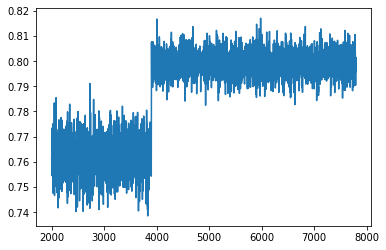

In [343]:
plt.plot(x[2000:],y[2000:])

In [522]:
cov_diff_upd(dataset.X)

0.02817137777204262

In [ ]:
last_cov_diff = {}
best_cov_diff = {}
best_test_loss_cov_diff = {}

In [ ]:
EPOCHS = 60
for lamb in np.linspace(0.1, 6., 10):
    min_test_loss = np.inf
    min_cov_diff = np.inf
    model.epsilon = lamb
    model.Gen.apply(weights_init)
    for disc in model.Discs:
        disc.apply(weights_init);
    for epoch in range(EPOCHS):
        cov_diff_fn = cov_metric(average=average_cov)
        #if epoch > 0:
        for key in model.metrics_names:
            model.logs[key][epoch] = {}
        model.logs['weights'][epoch] = {}
        for iteration, _data in enumerate(data_dl):
            if _data.shape[0] !=BATCH_SIZE:
                continue
            lr_scheduler(epoch, model)

            ############################
            # (1) Update D network CRITIC_ITERS iterations
            ###########################
            if CUDA:
                _data = _data.cuda()
            model.disc_train(_data, cov_diff_fn.update, epoch=epoch, iteration=iteration)
            model.disc_loss(noise_test,real_data_test, epoch=epoch, iteration=iteration)
            if iteration % CRITIC_ITERS == CRITIC_ITERS - 1 :
                ############################
                # (2) Update G network
                ###########################
                #ms = model.optimizerG.state_dict()
                model.gen_train(real_data=_data, cov_diff_fn=cov_diff_fn.update, epoch=epoch, iteration=iteration)
                model.gen_loss(noise_test, cov_diff_fn.update, real_data_test, epoch, iteration)
                metrics = [model.logs[key][epoch][iteration] for key in model.metrics_names]
                print(('epoch: {}, iter: {}, '+': {:.5f}, '.join(model.metrics_names) + ': {:.5f},').format(epoch,
                                                                                    iteration,*metrics))
                #model.logs['weights'][epoch][iteration] = [model.Gen.state_dict()]+ \
                #                            [disc.state_dict() for disc in model.Discs]
                
        

            cur_test_loss = model.logs['Sink cost test'][epoch][iteration]
            weight = model.Gen.main[0].weight.cpu().data.numpy()
            cur_cov_diff = np.linalg.norm(weight.dot(weight.T) - cov_diff_fn.optimal_cov)
            if cur_test_loss < min_test_loss:
                best_test_loss_cov_diff[lamb] = cur_cov_diff
                min_test_loss = cur_test_loss
            if cur_cov_diff < min_cov_diff:
                best_cov_diff[lamb] = cur_cov_diff
                min_cov_diff = cur_cov_diff
            last_cov_diff[lamb] = cur_cov_diff
            
        if epoch >= 120:
            model.optimizerG.swap_swa_sgd()
        print([best_test_loss_cov_diff, best_cov_diff, last_cov_diff])

In [28]:
weight = model.Gen.main[0].weight.cpu().data.numpy()
np.linalg.norm(weight.dot(weight.T) - cov_diff_fn.optimal_cov)

0.7121784079060081

In [27]:
weight.shape

(32, 32)

In [71]:
res = {}
for lamb in [3.0, 4.0, 5.0]:
    with open('./training_linear/v2_SINKHORN_NP_LATENT_DIM_32_initialization_he_LAMBDA_3.0_v2_linear.pkl', 'rb') as f:
        res = pkl.load(f)

In [53]:
for epoch in res['weights']:
    for it in res['weights'][epoch]:
        res['weights'][epoch][it][0]['main.0.weight'] = res['weights'][epoch][it][0]['main.0.weight'].cpu()
        res['weights'][epoch][it][0]['main.0.bias'] = res['weights'][epoch][it][0]['main.0.bias'].cpu()

In [52]:
res['weights'][0][0][0]['main.0.bias']

tensor([-0.0023,  0.0018,  0.0036,  0.0018, -0.0024,  0.0033, -0.0055,  0.0004,
         0.0026,  0.0046, -0.0009, -0.0025, -0.0030,  0.0041, -0.0023, -0.0013,
         0.0013, -0.0037,  0.0007, -0.0002,  0.0011, -0.0087, -0.0013,  0.0035,
        -0.0023, -0.0006,  0.0014, -0.0017, -0.0048, -0.0024,  0.0015,  0.0015],
       device='cuda:0')

In [62]:
with open('./training_linear/v2_SINKHORN_NP_LATENT_DIM_32_initialization_he_LAMBDA_3.0_v2_linear.pkl', 'wb') as f:
    pkl.dump(res, f)

In [55]:
res.keys()

dict_keys(['Sink cost', 'cov diff', 'Sink cost test', 'cov diff test', 'lambda', 'batch size', 'critic iters', 'mode', 'weights'])

In [61]:
res['weights'][0][0]

[OrderedDict([('main.0.weight',
               tensor([[-0.1358,  0.0384, -0.1119,  ..., -0.1437,  0.0966, -0.0757],
                       [-0.0175,  0.0417, -0.0140,  ..., -0.0048, -0.0500,  0.1723],
                       [-0.0854,  0.0082, -0.0724,  ...,  0.0308, -0.0873, -0.0071],
                       ...,
                       [ 0.0300,  0.0304, -0.1116,  ...,  0.1114, -0.0205,  0.0663],
                       [ 0.0121,  0.0151,  0.0769,  ..., -0.1432, -0.1358, -0.0477],
                       [ 0.0416, -0.0466,  0.0092,  ..., -0.0991, -0.0124,  0.0918]])),
              ('main.0.bias',
               tensor([-0.0023,  0.0018,  0.0036,  0.0018, -0.0024,  0.0033, -0.0055,  0.0004,
                        0.0026,  0.0046, -0.0009, -0.0025, -0.0030,  0.0041, -0.0023, -0.0013,
                        0.0013, -0.0037,  0.0007, -0.0002,  0.0011, -0.0087, -0.0013,  0.0035,
                       -0.0023, -0.0006,  0.0014, -0.0017, -0.0048, -0.0024,  0.0015,  0.0015]))])]